# Multi-density DBSCAN

As seen in our pitch classification notebook, the DBSCAN with KMeans approach can break down in a number of situations. One of them is when the density of the clusters is different. DBSCAN has a global density criterion, making it unable to identify clear sparse clusters unless the user tunes the model parameters just right.

## Problem

### Toy example

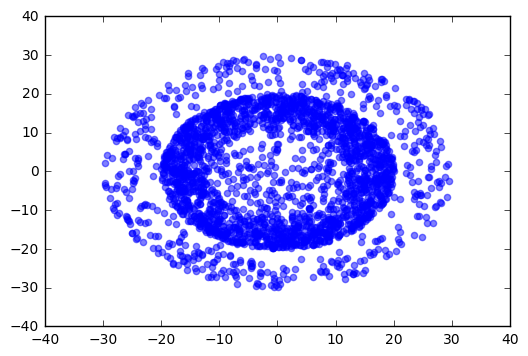

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# create circular uniform data
radius = 10
theta = 2*np.pi*np.random.uniform(size=150)
r = radius*np.sqrt(np.random.uniform(size=150))
x1 = r*np.cos(theta)
y1 = r*np.sin(theta)

r = radius+radius*np.sqrt(np.random.uniform(size=2000))
theta = 2*np.pi*np.random.uniform(size=2000)
x2 = r*np.cos(theta)
y2 = r*np.sin(theta)

r = 2*radius+radius*np.sqrt(np.random.uniform(size=500))
theta = 2*np.pi*np.random.uniform(size=500)
x3 = r*np.cos(theta)
y3 = r*np.sin(theta)

xx = np.concatenate((x1, x2, x3))
yy = np.concatenate((y1, y2, y3))
dat = np.column_stack((xx, yy))

plt.scatter(xx, yy, color="blue", alpha=0.5)
plt.show()

Here, there is a sparse circle surrounded by a dense ring and another sparse circle. Ideally, I would like to find three clusters: the circle and the two rings. This is an extreme example but will make clear the issue with DBSCAN's performance in this scenario.

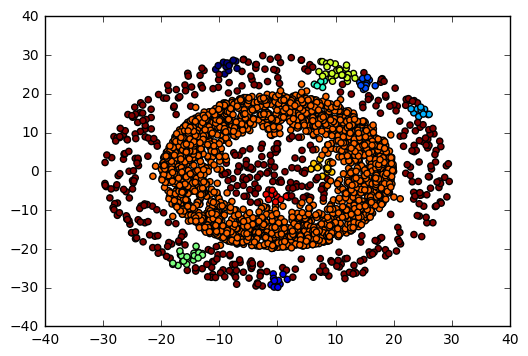

In [2]:
# imports
from sklearn.cluster import DBSCAN

# standardize data
dat_std = (dat-dat.mean(axis=0))/dat.std(axis=0)

# run dbscan
dbscan = DBSCAN(eps=0.15,
                min_samples=10,
                metric="euclidean",)

# fit and predict labels with dbscan
label_dbscan = dbscan.fit_predict(dat_std)

# plot dbscan
plt.scatter(xx, yy, c=label_dbscan, alpha=1, cmap="jet_r")
plt.show()

While the the dense ring and a few points inside and outside of the ring are identified as clusters, for the most part, anything not part of the dense ring is considered an outlier. There is no set of parameters that can identify the three modeled clusters when using DBSCAN.

### Roy Halladay example

From our pitch classification notebook, there were issues with clustering pitches for Roy Halladay because he did not throw his changeup nearly as often as his other pitches. I'll first show the result of DBSCAN here.

In [3]:
# imports
import sqlite3
import sys
sys.path.append('../src')
from DBSCANKMeans import DBSCANKMeans
from Player import Player

# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)

# grab pitches
rh = Player("Roy Halladay")
rh_pfx = rh.pitches(db, clean=1)

# grab intuitive features
rh_pfx_intuit = rh_pfx[["ax",
                        "az",
                        "start_speed",]]

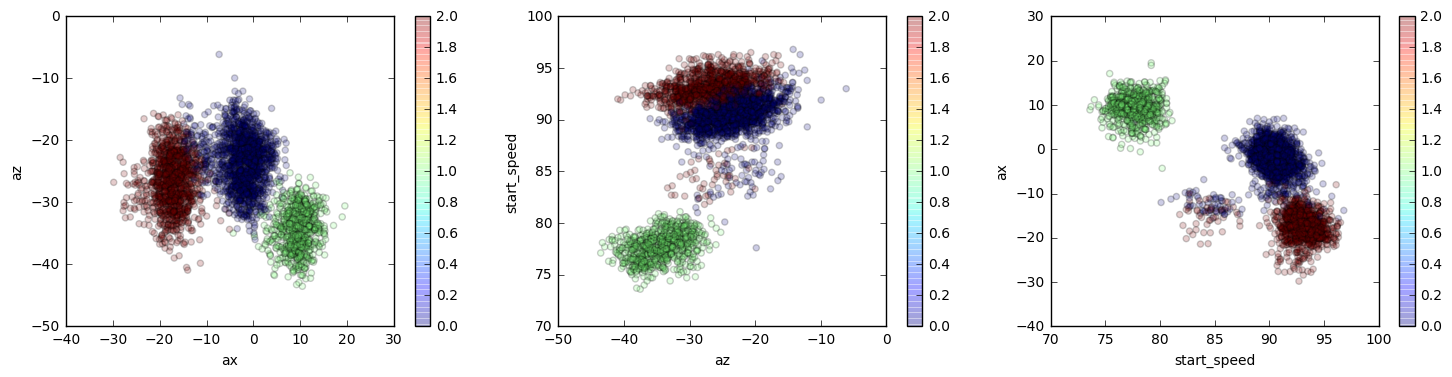

In [4]:
# create function for cross plots
def xplot3(dataframe3, ax0, ax1, ax2, *label):
    """Create crossplots of over three variables
    
    Input:
        dataframe3: pd dataframe
        ax0: feature string 1
        ax1: feature string 2
        ax2: feature string 3
        label: optional color label (if not specified then plots the third axis)
        
    Outputs:
        crossplots over all combinations of three features
    """
    # check if color label
    if label:
        col = [label[0] for ii in range(3)]
    else:
        col = [dataframe3[ax2], dataframe3[ax0], dataframe3[ax1]]

    # initialize subplots and feature vector
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    axes = [ax0, ax1, ax2, ax0, ax1]
    
    # loop over figures
    for ii in range(3):
        pp = ax[ii].scatter(dataframe3[axes[ii]],
                            dataframe3[axes[ii+1]],
                            c=col[ii],
                            cmap="jet",
                            alpha=0.2)
        ax[ii].set_xlabel(axes[ii])
        ax[ii].set_ylabel(axes[ii+1])
        if label:
            plt.colorbar(pp, ax=ax[ii])
        else:
            plt.colorbar(pp, ax=ax[ii], label=axes[ii+2])
    
    plt.show()
    
    # clean up
    return

# cluster
dbk = DBSCANKMeans(q=80)
labels_dbk = dbk.fit_predict(rh_pfx_intuit, stand=1)
xplot3(rh_pfx, "ax", "az", "start_speed", labels_dbk)

No matter how the `eps` and `min_points` parameters are tuned in DBSCAN, the sparse cluster (most visible when plotting horizontal acceleration `ax` against `start_speed`) will not be considered its own cluster (at least without merging the two clusters with high velocity). I will look at whether a multi-density DBSCAN approach can work here.

## Method

Here, I investigate the suitability of a multi-density DBSCAN proposed by Wesam and Saad, 2011 (https://www.researchgate.net/profile/Wesam_Ashour/publication/296679011_69360446/links/56d8179608aebabdb404f801.pdf).

The method is similar to DBSCAN in that the number of clusters does not need to be known apriori. Here is a brief description of the steps.

1) Calculate and store the average distance (here, Euclidean) of the `k` nearest neighbors for each data point. `k` is like `eps` in DBSCAN, in that it determines the size of the region over which density is defined. The smaller the average distance, the higher the local density is around that data point.

2) Assign the data point with the highest local density (in other words, the data point with the smallest average distance to its neighbors) to a new cluster. Remove data point from the stored local density list.

3) Initialize the average distance for the chosen data point to be the initial average distance of the new cluster.

4) For each of the K nearest neighbors for the selected data point, compare the average distance of the current cluster with the average distance of the K nearest neighbors for the data point in question. If the cluster average distance is less than the data point's averaged distance scaled by some parameter `var`, add that data point to the current cluster. Then remove the data point from the stored average distance list.

5) If a data point is added in step 4, repeat step 4 for the added data point. Repeat this step until no further data points can be added.

6) Repeat steps 2-5 for all remaining data points. New clusters are initialized here.

Essentially, clusters grow out from a single data point based on whether the average distance of the cluster is less than the average distance around the data point in question, up to some threshold. The process is repeated until there are no more data points to be considered. The MultiDBSCAN class is found below.

In [5]:
import sys
from sklearn.neighbors import NearestNeighbors
sys.setrecursionlimit(10000)

class MultiDBSCAN():
    """Multi-density DBSCAN
    
    Algorithm to discover clusters with different densities.
    Based on "Multi Density DBSCAN", Wesam and Saad, 2011.
    """
    def __init__(self, k, var):
        """Initialize multi_dbscan object
        
        Inputs:
            k: number of nearest neighbors
            var: variance, greater than 1
        """
        self.k = k
        self.var = var
        
    def fit_predict(self, X):
        """Fit multi-dbscan and predict labels
        
        Inputs:
            X: standardized data points [n_observations, n_features]
        """
        # pass input
        self.X = X
        
        # find K nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=self.k,
                                metric="euclidean")
        nbrs_fit = nbrs.fit(self.X)
        self.k_dist, self.k_ind = nbrs_fit.kneighbors(self.X)
    
        # create average distance of k nearest neighbors for each point
        self.aDST = dict(enumerate(np.sum(self.k_dist, axis=1)/(self.k-1)))

        # initialize cluster at densest point
        self.clusters = {}
        self.nclust = 0
        while self.aDST:
            idat = min(self.aDST, key=self.aDST.get)
            self.clusters[self.nclust] = [idat]
            self.cluster_aDST = self.aDST[idat]
            self.aDST.pop(idat, None)
            self.cluster_expand(idat)
            if len(self.clusters[self.nclust])<20:
                self.clusters.pop(self.nclust, None)
            self.nclust += 1
        
        # clean up
        return self.clusters

    def cluster_expand(self, idat):
        """Expand cluster recursively"""
        for qq in self.k_ind[idat, :]:
            if (qq in self.aDST) and (self.aDST[qq]<=self.var*self.cluster_aDST):
                # add index to cluster
                self.clusters[self.nclust].append(qq)
                lcluster = len(self.clusters[self.nclust])
                self.cluster_aDST = (self.cluster_aDST*(lcluster-1)+self.aDST[qq])/lcluster
                self.aDST.pop(qq, None)
                self.cluster_expand(qq)

## Results

### Toy example

Let's return to our toy example, where there was a sparse set of data points surrounded by a dense ring of points and a spare ring of points. The results of multi-density DBSCAN for that example is below.

In [6]:
# run multi-density DBSCAN
dat_std = (dat-dat.mean(axis=0))/dat.std(axis=0)
mdbscan = MultiDBSCAN(10, 2)
dist = mdbscan.fit_predict(dat_std)

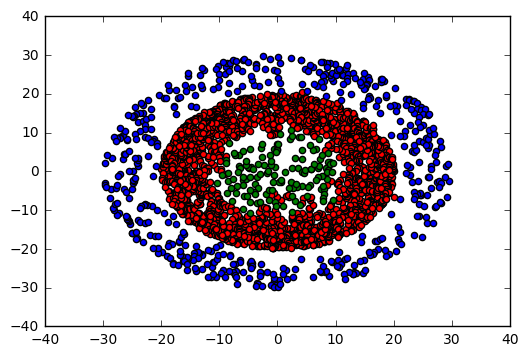

In [7]:
colors = ["red", "blue", "green", "orange", "yellow"]
ccount = 0
for ii in dist:
    plt.scatter(dat[dist[ii], 0],
                dat[dist[ii], 1],
                c=colors[ccount],)
    ccount += 1
plt.show()

After tuning the input parameters `k` and `var` a bit, there are reasonable clusters that are based on density of points. However, quite a bit of tuning went into creating these clusters.

### Roy Halladay example

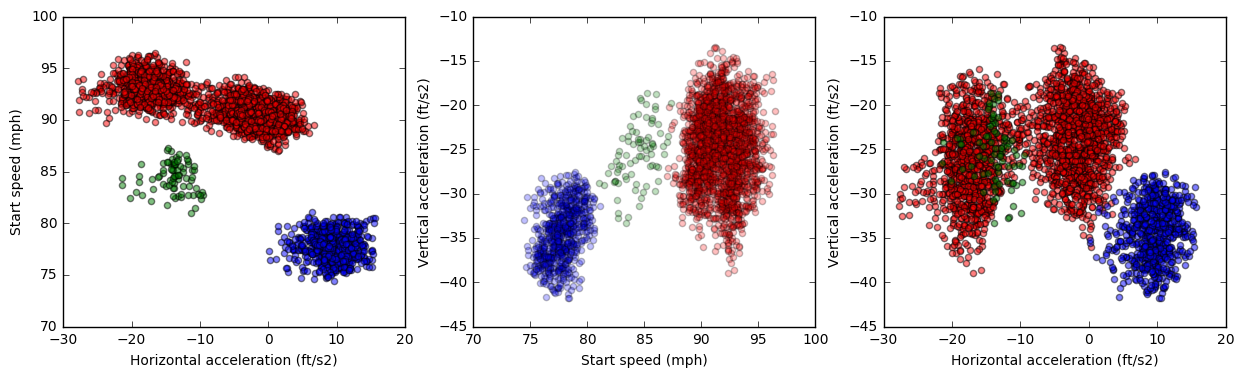

In [8]:
# cluster
mdbscan = MultiDBSCAN(5, 3)
dist = mdbscan.fit_predict(rh_pfx_intuit)

# plot
colors = ["red", "blue", "green", "orange", "yellow"]
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ccount = 0
for ii in dist:
    ax[0].scatter(rh_pfx_intuit.iloc[dist[ii], 0],
                  rh_pfx_intuit.iloc[dist[ii], 2],
                  c=colors[ccount],
                  alpha=0.5)
    ccount += 1
    ax[0].set_xlabel("Horizontal acceleration (ft/s2)")
    ax[0].set_ylabel("Start speed (mph)")
    
ccount = 0
for ii in dist:
    ax[1].scatter(rh_pfx_intuit.iloc[dist[ii], 2],
                  rh_pfx_intuit.iloc[dist[ii], 1],
                  c=colors[ccount],
                  alpha=0.25)
    ccount += 1
    ax[1].set_xlabel("Start speed (mph)")
    ax[1].set_ylabel("Vertical acceleration (ft/s2)")
    
ccount = 0
for ii in dist:
    ax[2].scatter(rh_pfx_intuit.iloc[dist[ii], 0],
                  rh_pfx_intuit.iloc[dist[ii], 1],
                  c=colors[ccount],
                  alpha=0.5)
    ccount += 1
    ax[2].set_xlabel("Horizontal acceleration (ft/s2)")
    ax[2].set_ylabel("Vertical acceleration (ft/s2)")
    
plt.show()

After tuning the parameters, there is another cluster (green) corresponding to his changeup. However, the two clusters with high velocity that were separated by DBSCAN are now one single cluster.

Therefore, the multi-density DBSCAN approach here has its own set of challenges when clustering data points. In particular, the approach has problems when clusters are not well separated, such as the two fastball clusters here. In this case, I could try to separate the clusters by making the criterion for similar densities between the cluster density and the local density of the data point in question more strict (by decreasing `var`) or by decreasing the number of neighbors used for local denisty estimates (by decreasing `k`). However, modifying either of these parameters leads to other clusters being formed within the clusters with lower velocity.

## Final thoughts

Multi-density DBSCAN attempts to cluster data points together by comparing their local densities. Like with any clustering algorithm, the approach here has its pros and cons.

### Strengths

1) The number of clusters does not need to be specified beforehand.

2) Adjacent and well-separated groups of data points with different densities can be clustered.

### Limitations

1) Parameters that control the local density estimate for each data point and the threshold density for a new data point to be added to a cluster must be tuned for different data sets.

2) Data points considered to be outliers by DBSCAN (such as the fringe data points around tight clusters) are considered to be their own clusters using this approach. As a result, the natural tapering off of data-point density from the cluster centroid can mistakenly lead to the identification of multiple clusters when there is truly only one.

3) Separation of nearby clusters with similar densities is challenging.

### Recommendation

The multi-density DBSCAN approach here works well where there are well-separated clusters and/or clusters with very different densities of data points. In the case of automatic pitch classification, this approach is unlikely to be generally much better than ordinary DBSCAN, as for the most part pitchers throw their off-speed and breaking pitches with similar frequencies. Additionally, many pitchers have pitches that are similar enough to each other that they are poorly separated. As seen here, the approach here struggles with nearby clusters with similar densities. Thus, it seems that the multi-density DBSCAN approach here should be deployed only in the special case where there is a clear cluster with a clearly different density than the other clusters.